In [348]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [349]:
# Cargar los datos del perfil NACA 0024 desde el archivo
perfil_data = np.loadtxt('Airfoil_DAT_Selig/naca0024.dat', skiprows=1)
perfil_x = perfil_data[:, 0]
perfil_y = perfil_data[:, 1]

# Parámetros de la simulación
U = 1.0  # velocidad de corriente libre
Lambda = 0.33  # intensidad de la fuente
n = 100 # número de sumideros
c = 1.0  # longitud de la cuerda
epsilon = 1e-5  # valor pequeño para evitar divisiones por cero

# Posiciones de la fuente y los sumideros
fuente_x, fuente_y = 0.08, 0.0
sumideros_x = np.linspace(0.2, c, n)
sumideros_y = np.zeros(n)
intensidad_sumidero = -Lambda / n

In [350]:
# Generar una malla de puntos para calcular las funciones de corriente
x = np.linspace(-1.0, 2.0, 200)
y = np.linspace(-1.0, 1.0, 200)
X, Y = np.meshgrid(x, y)

# Función de corriente para la corriente uniforme
psi_uniforme = U * Y

# Función de corriente para la fuente
psi_fuente = (Lambda / (2 * np.pi)) * np.arctan2(Y - fuente_y, X - fuente_x)

# Función de corriente para los sumideros
psi_sumideros = np.zeros_like(X)
for i in range(n):
    psi_sumideros += (intensidad_sumidero / (2 * np.pi)) * np.arctan2(
        Y - sumideros_y[i], X - sumideros_x[i]
    )

# Superposición de las funciones de corriente
psi_total = psi_uniforme + psi_fuente + psi_sumideros

In [351]:
# Determinar la parte superior del perfil
# La parte superior del perfil se define donde perfil_y es positivo o igual a cero
superior_indices = np.where(perfil_y >= 0)
perfil_x_superior = perfil_x[superior_indices]
perfil_y_superior = perfil_y[superior_indices]

# Cálculo de la distribución de velocidad sobre la superficie superior del perfil
Vx_total = np.full(perfil_x_superior.shape, U)  # Inicializar con la velocidad de la corriente libre
Vy_total = np.zeros_like(perfil_x_superior)

# Velocidad debida a la fuente
Vx_fuente = (Lambda / (2 * np.pi)) * (perfil_x_superior - fuente_x) / ((perfil_x_superior - fuente_x) ** 2 + (perfil_y_superior - fuente_y) ** 2)
Vy_fuente = (Lambda / (2 * np.pi)) * (perfil_y_superior - fuente_y) / ((perfil_x_superior - fuente_x) ** 2 + (perfil_y_superior - fuente_y) ** 2)

Vx_total += Vx_fuente
Vy_total += Vy_fuente

# Velocidad debida a los sumideros
for i in range(n):
    dx = perfil_x_superior - sumideros_x[i]
    dy = perfil_y_superior - sumideros_y[i]
    Vx_sumidero = (intensidad_sumidero / (2 * np.pi)) * dx / (dx ** 2 + dy ** 2)
    Vy_sumidero = (intensidad_sumidero / (2 * np.pi)) * dy / (dx ** 2 + dy ** 2)
    Vx_total += Vx_sumidero
    Vy_total += Vy_sumidero

# Magnitud de la velocidad total
velocidad_total = np.sqrt(Vx_total ** 2 + Vy_total ** 2)

# Cálculo del coeficiente de presión Cp
Cp = 1 - (velocidad_total / U) ** 2

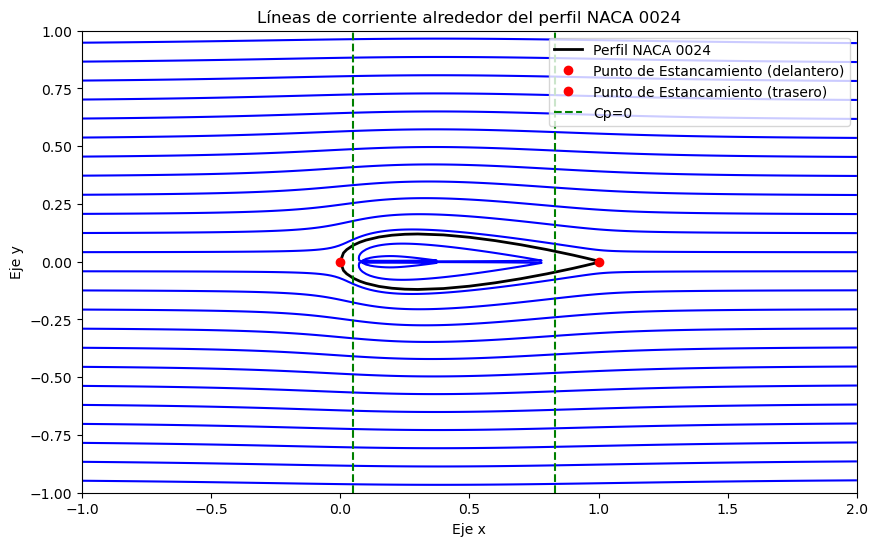

In [412]:
# Graficar el perfil NACA, líneas de corriente y puntos de estancamiento
plt.figure(figsize=(10, 6))
plt.contour(
    X,
    Y,
    psi_total,
    levels=np.linspace(-2, 2, 50),
    colors="blue",
    linestyles="solid",
)
plt.plot(
    perfil_x, perfil_y, "k-", linewidth=2, label="Perfil NACA 0024"
)  # Perfil NACA

# Marcar puntos de estancamiento (aproximados)
plt.plot(0, 0, "ro", label="Punto de Estancamiento (delantero)")
plt.plot(c, 0, "ro", label="Punto de Estancamiento (trasero)")

# Agregar líneas verticales en x=0.05 y x=0.8325
plt.axvline(x=0.05, color='g', linestyle='--')
plt.axvline(x=0.8325, color='g', linestyle='--', label='Cp=0')

# Título y etiquetas
plt.title(
    "Líneas de corriente alrededor del perfil NACA 0024"
)
plt.xlabel("Eje x")
plt.ylabel("Eje y")
plt.legend()

plt.show()

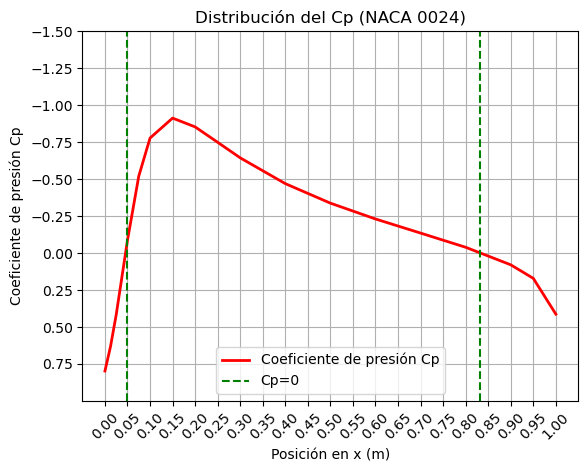

In [409]:
# Graficar Cp sobre el perfil
plt.figure()
plt.plot(perfil_x_superior, Cp, "r-", linewidth=2, label="Coeficiente de presión Cp")

# Agregar líneas verticales en x=0.05 y x=0.8325
plt.axvline(x=0.05, color='g', linestyle='--')
plt.axvline(x=0.8325, color='g', linestyle='--', label='Cp=0')

plt.xlabel("Posición en x (m)")
plt.ylabel("Coeficiente de presión Cp")
plt.title("Distribución del Cp (NACA 0024)")
plt.ylim(1, -1)
plt.yticks(np.arange(-1.5, 1, 0.25))
plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.grid()
plt.legend()
plt.show()


Text(0.5, 1.0, 'Distribución de Velocidad (NACA 0024)')

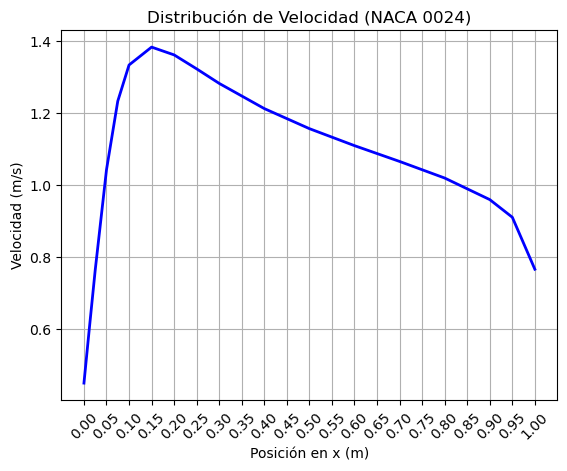

In [410]:
# Graficar distribución de velocidad sobre el perfil
plt.figure()
plt.plot(perfil_x_superior, velocidad_total, "b-", linewidth=2)
plt.xlabel("Posición en x (m)")
plt.ylabel("Velocidad (m/s)")
plt.grid()
plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.title("Distribución de Velocidad (NACA 0024)")

In [411]:
# Celda para calcular la velocidad en los puntos de estancamiento (0, 0) y (c, 0) e imprimir el resultado con formato .4f
puntos_estancamiento = [(0, 0), (c, 0)]
for i, (px, py) in enumerate(puntos_estancamiento):
    # Velocidad debida a la corriente libre
    Vx = U
    Vy = 0

    # Velocidad debida a la fuente
    Vx += (Lambda / (2 * np.pi)) * (px - fuente_x) / (((px - fuente_x) ** 2 + (py - fuente_y) ** 2) + epsilon)
    Vy += (Lambda / (2 * np.pi)) * (py - fuente_y) / (((px - fuente_x) ** 2 + (py - fuente_y) ** 2) + epsilon)

    # Velocidad debida a los sumideros
    for j in range(n):
        dx = px - sumideros_x[j]
        dy = py - sumideros_y[j]
        Vx += (intensidad_sumidero / (2 * np.pi)) * dx / ((dx ** 2 + dy ** 2) + epsilon)
        Vy += (intensidad_sumidero / (2 * np.pi)) * dy / ((dx ** 2 + dy ** 2) + epsilon)

    # Magnitud de la velocidad
    velocidad = np.sqrt(Vx ** 2 + Vy ** 2)
    print(f"Velocidad en el punto de estancamiento ({px}, {py}): {velocidad:.4f}")


Velocidad en el punto de estancamiento (0, 0): 0.4507
Velocidad en el punto de estancamiento (1.0, 0): 0.7312
